<a href="https://colab.research.google.com/github/AnkitaSK/AB-Image-Classification/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using pretrained model and using new output layer with the required number of classes


In [127]:
from keras.backend import clear_session
clear_session()

In [128]:
# importing libraries

import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

from zipfile import ZipFile
from urllib.request import urlretrieve

In [129]:
#!pip install gdown

In [130]:
# https://www.dropbox.com/scl/fi/yo7jgxcq7665hhtrqgv3t/fruits-360-original.zip?rlkey=0ubqqi50brnkyc7t9oj9xb7by&st=2zrc8ko3&dl=0

# https://www.dropbox.com/scl/fi/yo7jgxcq7665hhtrqgv3t/fruits-360-original.zip?rlkey=0ubqqi50brnkyc7t9oj9xb7by&st=pfq6f0pm&dl=1

In [131]:
# def download_and_unzip(url, save_path):
#     print(f"Downloading and extracting assets....", end="")

#     # Downloading zip file using urllib package.
#     urlretrieve(url, save_path)

#     try:
#         # Extracting zip file using the zipfile package.
#         with ZipFile(save_path) as z:
#             # Extract ZIP file contents in the same directory.
#             z.extractall(os.path.split(save_path)[0])

#         print("Done")

#     except Exception as e:
#         print("\nInvalid file.", e)

In [132]:
# URL = r"https://www.dropbox.com/scl/fi/yo7jgxcq7665hhtrqgv3t/fruits-360-original.zip?rlkey=0ubqqi50brnkyc7t9oj9xb7by&st=pfq6f0pm&dl=1"

# dataset_path   = os.path.join(os.getcwd(), "fruits-360-original")
# asset_zip_path = os.path.join(os.getcwd(), "fruits-360-original.zip")

# # Download if assest ZIP does not exists.
# # print(dataset_path)
# if not os.path.exists(asset_zip_path):
#     download_and_unzip(URL, asset_zip_path)
# else:
#     try:
#         # Extracting zip file using the zipfile package.
#         with ZipFile(asset_zip_path) as z:
#             # Extract ZIP file contents in the same directory.
#             z.extractall(os.path.split(asset_zip_path)[0])

#         print("Done")

#     except Exception as e:
#         print("\nInvalid file.", e)

In [133]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3

    DATA_ROOT_TRAIN:  str = os.path.join(dataset_path, "Training")
    DATA_ROOT_VALID:  str = os.path.join(dataset_path, "Validation")
    DATA_ROOT_TEST:   str = os.path.join(dataset_path, "Test")


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [134]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
# random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
# tf.random.set_seed(SEED_VALUE)

In [135]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# separating training and validation set
X_valid = X_train[:10000]
X_train = X_train[10000:]

y_valid = y_train[:10000]
y_train = y_train[10000:]


#normalize the data by dividing by 255 to scale the pixel values between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255


# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [136]:
# train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
#                                              batch_size=TrainingConfig.BATCH_SIZE,
#                                              shuffle=True,
#                                              seed=SEED_VALUE,
#                                              label_mode='int', # Use integer encoding
#                                              image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
#                                             )

# valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
#                                              batch_size=TrainingConfig.BATCH_SIZE,
#                                              shuffle=True,
#                                              seed=SEED_VALUE,
#                                              label_mode='int', # Use integer encoding
#                                              image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
#                                             )

# test_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TEST,
#                                              batch_size=TrainingConfig.BATCH_SIZE,
#                                              shuffle=True,
#                                              seed=SEED_VALUE,
#                                              label_mode='int', # Use integer encoding
#                                              image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
#                                             )

In [137]:
# print(train_dataset.class_names)

In [138]:
# class_names = train_dataset.class_names
# plt.figure(figsize=(18, 10))

# # Assumes dataset batch_size is at least 32.
# num_rows = 4
# num_cols = 8

# # Here we use the take() method to retrieve just the first batch of data from the test dataset.
# for image_batch, labels_batch in train_dataset.take(1):

#     # Plot each of the images in the batch and the associated ground truth labels.
#     for i in range(num_rows * num_cols):
#         ax = plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         truth_idx = labels_batch[i].numpy()
#         plt.title(class_names[truth_idx])
#         plt.axis("off")

In [139]:
# TODO - preprocess test_dataset images

In [140]:
# class_names = test_dataset.class_names
# plt.figure(figsize=(18, 10))

# # Assumes dataset batch_size is at least 32.
# num_rows = 4
# num_cols = 8

# # Here we use the take() method to retrieve just the first batch of data from the test dataset.
# for image_batch, labels_batch in test_dataset.take(1):

#     # Plot each of the images in the batch and the associated ground truth labels.
#     for i in range(num_rows * num_cols):
#         ax = plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         truth_idx = labels_batch[i].numpy()
#         plt.title(class_names[truth_idx])
#         plt.axis("off")

In [141]:
# fine tuning
# we need to redefine the classifier
# Load the ResNet50 model with pretrained ImageNet weights, excluding the top (fully connected) layers
# input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Freeze the Initial Layers in the Convolutional Base
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below)
base_model.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(base_model.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in base_model.layers[: num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} convolution layers")
print("\n")
base_model.summary()

FREEZING LAYER: <InputLayer name=input_layer, built=True>
FREEZING LAYER: <Conv2D name=block1_conv1, built=True>
FREEZING LAYER: <Conv2D name=block1_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block1_pool, built=True>
FREEZING LAYER: <Conv2D name=block2_conv1, built=True>
FREEZING LAYER: <Conv2D name=block2_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block2_pool, built=True>
FREEZING LAYER: <Conv2D name=block3_conv1, built=True>
FREEZING LAYER: <Conv2D name=block3_conv2, built=True>
FREEZING LAYER: <Conv2D name=block3_conv3, built=True>
FREEZING LAYER: <MaxPooling2D name=block3_pool, built=True>


Configured to fine tune the last 8 convolution layers




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [143]:
# Add the Classifier to Complete the Model
model = Sequential([
    base_model,  # Add the pretrained model (frozen initially)
    layers.GlobalAveragePooling2D(),  # Convert 4D tensor to 2D
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(TrainingConfig.DROPOUT),  # Prevent overfitting
    layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')  # CIFAR-10 has 10 classes
])

# TODO fine tune

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Train the model
training_results = model.fit(
    X_train,
    y_train,
    epochs=TrainingConfig.EPOCHS,
    validation_data=(X_valid, y_valid)
)

Epoch 1/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4989 - loss: 1.4861 - val_accuracy: 0.7461 - val_loss: 0.7566
Epoch 2/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7431 - loss: 0.8185 - val_accuracy: 0.7656 - val_loss: 0.7102
Epoch 3/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8064 - loss: 0.6151 - val_accuracy: 0.7770 - val_loss: 0.7166
Epoch 4/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8551 - loss: 0.4612 - val_accuracy: 0.7910 - val_loss: 0.7508
Epoch 5/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8914 - loss: 0.3473 - val_accuracy: 0.7926 - val_loss: 0.8117
Epoch 6/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9236 - loss: 0.2584 - val_accuracy: 0.7784 - val_loss: 0.9443
Epoch 7/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9388 - loss: 0.2016 - val_accuracy: 0.7860 - val_loss: 0.9690
Epoch 8/101
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9513 - loss: 

In [144]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('Text loss: ', test_loss)
# print(f'\nFine-tuned test accuracy: {test_acc:.4f}')

In [145]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

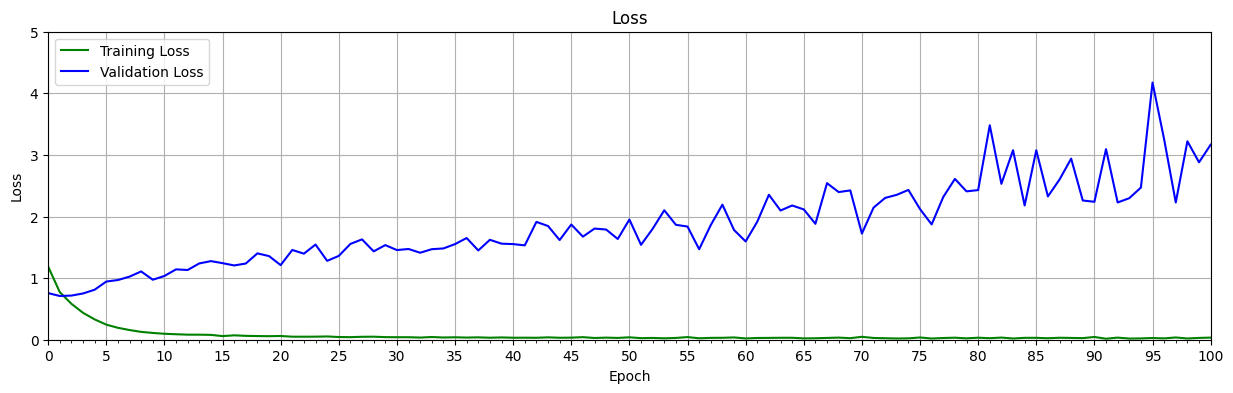

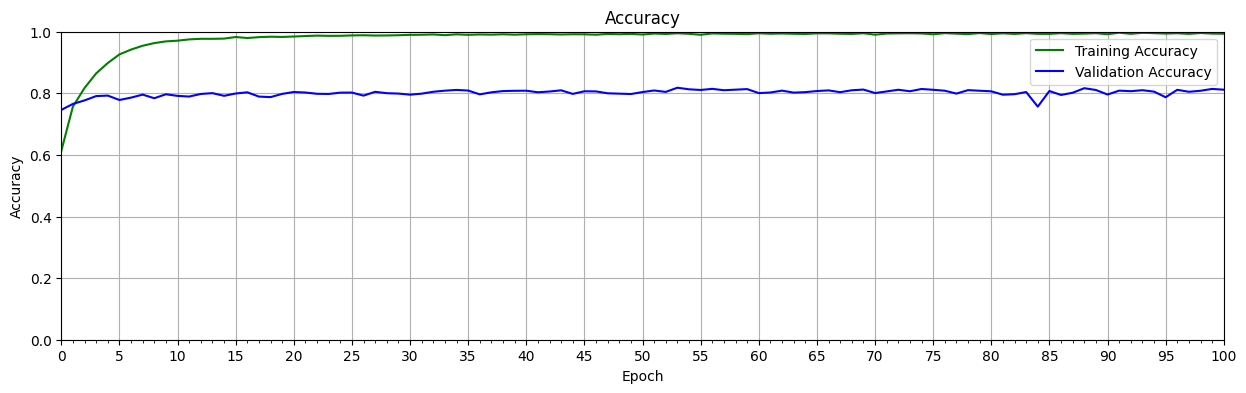

In [146]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

In [147]:
valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid)
print(f"Model valid accuracy: {valid_accuracy*100.:.3f}, Model valid loss: {valid_loss*100.:.3f}")
print("\n\n")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Model test accuracy: {test_accuracy*100.:.3f}, Model test loss: {test_loss*100.:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8146 - loss: 2.9853
Model valid accuracy: 81.180, Model valid loss: 316.530



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8026 - loss: 3.6715
Model test accuracy: 79.910, Model test loss: 395.296
